# Prepare Dataset

The problem we are dealing with, two-dimensional input `(longitude, latitude)` and one-dimensional output `height`. The ground truth is given by NCDC world wide weather station information.


In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot

## Loading Data

First, we load data from external data source file and prepare features `(longitude, latitude)` and labels `(elevate)`. Separate the data into training data and test data by using `mod`.

In [2]:
import os, datetime
from StringIO import StringIO

current_folder = os.path.join(os.path.expanduser('~'), 'python')
file_folder = os.path.join(current_folder, 'tutorial_files','weather')
data_folder = os.path.join(current_folder, 'tutorial_data', 'weather')

if not os.path.exists(data_folder):

    raw_data = open(os.path.join(file_folder,'Station.txt'), 'r').read()
    #print('Raw data looks like this:')
    #print(raw_data[966:1300] + '...')

    stations = np.genfromtxt(\
        StringIO(raw_data),\
        delimiter=(7,6,30,3,3,3,6,7,8,10,9,9),# width of each field \
        skip_header=22, # skip 22 lines of header \
        usecols=(8, 7, 9), # reorder colums from (latitude, longitude, elevate) to (longitude, latitude, elevate) \
        missing_values="-99999,-999999", # missing_values will be replaced by numpy.nan \
        dtype=[('longitude','f8'),('latitude','f8'),('elevate','f8')], # \
        usemask=True) # required by using missing_values

    # Convert masked array to numpy arrary and normalize (longitude, latitude, elevate)
    data_set = np.array([
        [stations[i][0]/1000/180, stations[i][1]/1000/90, stations[i][2]/10/10000]
        for i in range(len(stations)) if stations[i][0] and stations[i][1] and stations[i][2]
    ], np.float32)
    
    # Shuffle the data set
    random_index = np.random.permutation(len(data_set))
    #data_set = data_set[random_index]
    
    # Truncate the dataset by MOD 100
    data_set = data_set[:(len(data_set) - len(data_set)%100)]
    
    # Split the dataset into features and labels
    features = np.array([
        [t[0] for t in data_set],
        [t[1] for t in data_set]
    ], dtype=np.float32)
    labels = np.array([
        [t[2]] for t in data_set 
    ], dtype=np.float32)
    
    #reshape the data set from (28300, 1) to (283, 1, 10, 10)
    features = features.reshape(len(data_set)/100, 2, 10, 10)
    labels = labels.reshape(len(data_set)/100, 100)

    train_features = features[0:250]
    train_labels = labels[0:250]
    test_features = features[250:260]
    test_labels = labels[250:260]

## Write to MiniDB as Caffe2Tensor

In [3]:
from caffe2.python import core, utils
from caffe2.proto import caffe2_pb2
import shutil

# Now, actually write the db.
def write_db(db_type, db_name, features, labels):
    db = core.C.create_db(db_type, db_name, core.C.Mode.write)
    transaction = db.new_transaction()
    for i in range(features.shape[0]):
        feature_and_label = caffe2_pb2.TensorProtos()
        feature_and_label.protos.extend([
            utils.NumpyArrayToCaffe2Tensor(features[i]),
            utils.NumpyArrayToCaffe2Tensor(labels[i])])
        transaction.put(
            'train_{:0=5}'.format(i),
            feature_and_label.SerializeToString())
    # Close the transaction, and then close the db.
    del transaction
    del db

if not os.path.exists(data_folder):
    os.makedirs(data_folder)
    write_db("minidb", os.path.join(data_folder, 'weather-station-train-minidb'), train_features, train_labels)
    write_db("minidb", os.path.join(data_folder, 'weather-station-test-minidb'), test_features, test_labels)

# Modeling

## Declaring the computation graphs


In [4]:
from caffe2.python import workspace, brew, model_helper

def AddInput(model, batch_size, db, db_type):
    # load the data
    data, label = model.TensorProtosDBInput(
        [], ["data", "label"], batch_size=batch_size,
        db=db, db_type=db_type)
    return data, label

def AddModel(model, data):
    # Image size: 2 x 10 x 10 -> 20 x 8 x 8
    conv1 = brew.conv(model, data, 'conv1', dim_in=2, dim_out=20, kernel=3)
    # Image size: 20 x 8 x 8 -> 40 x 6 x 6
    conv2 = brew.conv(model, conv1, 'conv2', dim_in=20, dim_out=40, kernel=3)
    # Image size: 40 x 6 x 6 -> 100 x 4 x 4
    conv3 = brew.conv(model, conv2, 'conv3', dim_in=40, dim_out=100, kernel=3)
    # Image size: 50 x 6 x 6 -> 500 x ? x ?
    fc1 = brew.fc(model, conv3, 'fc1', dim_in=100*4*4, dim_out=100)
    #
    predict = brew.softmax(model, fc1, 'predict')
    return predict

def AddAccuracy(model, predict, label):
    dist = model.SquaredL2Distance([predict, label], "dist")
    loss = model.AveragedLoss(dist, "loss")
    return loss

def AddTrainingOperators(model, predict, label):
    # track the loss of the model
    loss = AddAccuracy(model, predict, label)
    # use the average loss we just computed to add gradient operators to the model
    model.AddGradientOperators([loss])
    # do a simple stochastic gradient descent
    ITER = brew.iter(model, "iter")
    # set the learning rate schedule
    LR = model.LearningRate(
        ITER, "LR", base_lr=-0.1, policy="step", stepsize=1, gamma=0.999 )
    # ONE is a constant value that is used in the gradient update. We only need
    # to create it once, so it is explicitly placed in param_init_net.
    ONE = model.param_init_net.ConstantFill([], "ONE", shape=[1], value=1.0)
    # Now, for each parameter, we do the gradient updates.
    for param in model.params:
        # Note how we get the gradient of each parameter - CNNModelHelper keeps
        # track of that.
        param_grad = model.param_to_grad[param]
        # The update is a simple weighted sum: param = param + param_grad * LR
        model.WeightedSum([param, ONE, param_grad, LR], param)

In [5]:
arg_scope = {"order": "NCHW"}

# Training model 
train_model = model_helper.ModelHelper(name="ws_train", arg_scope=arg_scope)
data, label = AddInput(
    train_model, batch_size=250,
    db=os.path.join(data_folder, 'weather-station-train-minidb'),
    db_type='minidb')
predict = AddModel(train_model, data)
AddTrainingOperators(train_model, predict, label)
# initialize the train model
workspace.RunNetOnce(train_model.param_init_net)
# creating the train network
workspace.CreateNet(train_model.net, overwrite=True)

True

In [6]:
# Testing model 
test_model = model_helper.ModelHelper(name="ws_test", arg_scope=arg_scope, init_params=False)
data, label = AddInput(
    test_model, batch_size=1,
    db=os.path.join(data_folder, 'weather-station-test-minidb'),
    db_type='minidb')
_predict = AddModel(test_model, data)
predict = AddAccuracy(test_model, _predict, label)
# initialize the test model
workspace.RunNetOnce(test_model.param_init_net)
# creating the test network
workspace.CreateNet(test_model.net, overwrite=True)

True

In [7]:
# Deploy model
deploy_model = model_helper.ModelHelper(name="ws_deploy", arg_scope=arg_scope, init_params=False)
_predict = AddModel(test_model, data)
# initialize the deploy model
workspace.RunNetOnce(test_model.param_init_net)
# creating the deploy network
workspace.CreateNet(test_model.net, overwrite=True)

True

# Training

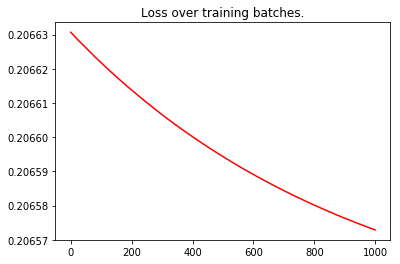

In [15]:
# set the number of iterations and track the accuracy & loss
total_iters = 1000
#accuracy = np.zeros(total_iters)
loss = np.zeros(total_iters)
# Now, we will run the training network 
for i in range(total_iters):
    workspace.RunNet(train_model.net)
    #accuracy[i] = workspace.FetchBlob('accuracy')
    loss[i] = workspace.FetchBlob('loss')
pyplot.plot(loss, 'r')
pyplot.title('Loss over training batches.')

# Testing

0.035180556587874889

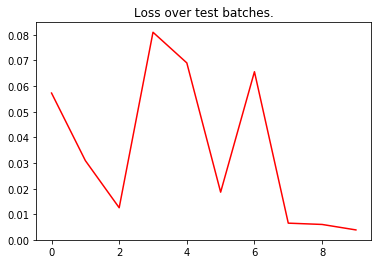

In [12]:
# set the number of iterations and track the accuracy & loss
total_iters = 10
#test_accuracy = np.zeros(total_iters)
test_loss = np.zeros(total_iters)
# Now, we will run the test network 
for i in range(total_iters):
    workspace.RunNet(test_model.net)
    #accuracy[i] = workspace.FetchBlob('accuracy')
    test_loss[i] = workspace.FetchBlob('loss')
    
pyplot.plot(test_loss, 'r')
pyplot.title('Loss over test batches.')
test_loss.mean()

In [16]:
workspace.FetchBlob("predict")[0,10:20]

array([ 0.00900407,  0.01044764,  0.00955431,  0.01038362,  0.01017025,
        0.01002423,  0.01016967,  0.01003155,  0.0105635 ,  0.01041587], dtype=float32)

In [17]:
workspace.FetchBlob("label")[0,10:20]

array([ 0.0014,  0.0008,  0.0029,  0.0005,  0.0013,  0.001 ,  0.0009,
        0.0014,  0.002 ,  0.0006], dtype=float32)